In [186]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [356]:
trainfile = r'/gdrive/My Drive/CIS 508/Assignments/Santander Customer Satisfaction - TRAIN.csv'
trainData = pd.read_csv(trainfile)

#Read test data file
testfile = r'/gdrive/My Drive/CIS 508/Assignments/Santander Customer Satisfaction - TEST-Without TARGET.csv'
testData = pd.read_csv(testfile)
trainData.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,...,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,saldo_medio_var13_medio_hace2,saldo_medio_var13_medio_hace3,saldo_medio_var13_medio_ult1,saldo_medio_var13_medio_ult3,saldo_medio_var17_hace2,saldo_medio_var17_hace3,saldo_medio_var17_ult1,saldo_medio_var17_ult3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,300.0,122.22,300.0,240.75,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3.00,2.07,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,0.0,195.0,195.0,0.0,0.0,195.0,0.0,0.0,195.0,0.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,91.56,138.84,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,...,40501.08,13501.47,0.0,0.0,0.0,0.0,0.0,0.0,85501.89,85501.89,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979,0


# Exploratory Data Analysis


In [357]:
#Checking shape of training and testing datasets
print("Train data shape: ", trainData.shape)
print("Test data shape: ", testData.shape)

Train data shape:  (76020, 371)
Test data shape:  (75818, 370)


In [358]:
#check data type
trainData.dtypes

ID                           int64
var3                         int64
var15                        int64
imp_ent_var16_ult1         float64
imp_op_var39_comer_ult1    float64
                            ...   
saldo_medio_var44_hace3    float64
saldo_medio_var44_ult1     float64
saldo_medio_var44_ult3     float64
var38                      float64
TARGET                       int64
Length: 371, dtype: object

In [359]:
#Descriptive statistics
trainData.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,...,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,saldo_medio_var13_medio_hace2,saldo_medio_var13_medio_hace3,saldo_medio_var13_medio_ult1,saldo_medio_var13_medio_ult3,saldo_medio_var17_hace2,saldo_medio_var17_hace3,saldo_medio_var17_ult1,saldo_medio_var17_ult3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.0,76020.0,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000,7.602000e+04,7.602000e+04,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,7.602000e+04,76020.000000,76020.0,76020.000000,76020.000000,7.602000e+04,7.602000e+04,7.602000e+04,7.602000e+04,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,3.160715,68.803937,113.056934,68.205140,113.225058,137.242763,68.618087,113.792410,140.403479,5.477676,0.011458,0.003762,0.0,0.0,0.958024,0.663760,0.000105,0.000026,0.032833,0.028598,0.067522,0.045462,0.052249,0.042936,0.041476,0.010168,0.009997,0.000026,0.000026,0.050855,...,1077.256756,1048.856447,68.275452,9.505287,124.620962,110.026575,3.997023e+03,613.534443,5.703008e+03,4.401002e+03,3639.419939,556.184178,4852.261814,3857.848542,771.227449,162.170439,9.569502e+02,7.509563e+02,0.175324,0.0,0.513023,0.344174,9.117181e+01,3.646318e+01,1.310316e+02,1.092169e+02,0.213071,0.001910,0.253907,0.186630,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,95.268204,319.605516,512.154823,531.897917,950.086398,697.712596,535.473750,953.578624,712.767240,465.391149,0.106425,0.061221,0.0,0.0,0.200535,0.472425,0.010258,0.005129,0.178202,0.166674,0.250925,0.208316,0.222531,0.202714,0.199390,0.100325,0.099486,0.005129,0.005129,0.219703,...,9614.906985,8189.948852,1733.838226,519.389157,2205.249804,1935.305713,3.777314e+04,9292.752726,4.620254e+04,3.550718e+04,26359.174223,7182

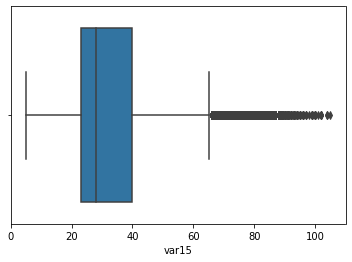

In [360]:
#Detecting outliers based on descriptive statistics
sns.boxplot(trainData["var15"])

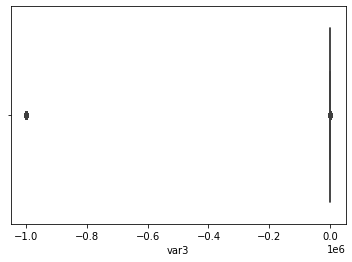

In [361]:
sns.boxplot(trainData["var3"]) #outlier- -999999

In [362]:
#Counting outliers in each column
trainData.groupby('var3')['var3'].count().sort_values(ascending =False)
testData.groupby('var3')['var3'].count().sort_values(ascending =False)


var3
 2         73962
-999999      120
 8           116
 9           108
 3           107
           ...  
 131           1
 55            1
 57            1
 62            1
 238           1
Name: var3, Length: 199, dtype: int64

In [0]:
# Replace -999999 with the most common value 2
trainData = trainData.replace(-999999,2)
testData = testData.replace(-999999,2)

In [364]:
#Remove ID column- irrelavent for data analysis
trainData=trainData.drop(["ID"],axis=1)
trainData.head(5)

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,ind_var14_0,...,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,saldo_medio_var13_medio_hace2,saldo_medio_var13_medio_hace3,saldo_medio_var13_medio_ult1,saldo_medio_var13_medio_ult3,saldo_medio_var17_hace2,saldo_medio_var17_hace3,saldo_medio_var17_ult1,saldo_medio_var17_ult3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170,0
1,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,300.0,122.22,300.0,240.75,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030,0
2,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3.00,2.07,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770,0
3,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,0.0,195.0,195.0,0.0,0.0,195.0,0.0,0.0,195.0,0.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,91.56,138.84,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970,0
4,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,...,40501.08,13501.47,0.0,0.0,0.0,0.0,0.0,0.0,85501.89,85501.89,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979,0


In [365]:
#Check for missing values
print("Null values in trainData= ", trainData.isnull().sum().sum())
print("Null values in testData= ",testData.isnull().sum().sum())

Null values in trainData=  0
Null values in testData=  0


In [366]:
#Remove columns with std dev=0: Has constant values- does not contribute to classification model
col_removed=0
for (columnName, columnData) in trainData.iteritems():
  std_dev=round(trainData[columnName].std(),2)
  if std_dev==0:
    trainData=trainData.drop(columns=columnName)
    testData=testData.drop(columns=columnName)
    print(columnName)
    col_removed=col_removed+1

print("Removed ",col_removed,"from trainData, Shape of trainData: ", trainData.shape)
print("Removed ",col_removed,"from testData, Shape of testData: ", testData.shape)

ind_var2_0
ind_var2
ind_var27_0
ind_var28_0
ind_var28
ind_var27
ind_var41
ind_var46_0
ind_var46
num_var27_0
num_var28_0
num_var28
num_var27
num_var41
num_var46_0
num_var46
saldo_var28
saldo_var27
saldo_var41
saldo_var46
imp_amort_var18_hace3
imp_amort_var34_hace3
imp_reemb_var13_hace3
imp_reemb_var33_hace3
imp_trasp_var17_out_hace3
imp_trasp_var33_out_hace3
num_var2_0_ult1
num_var2_ult1
num_reemb_var13_hace3
num_reemb_var33_hace3
num_trasp_var17_out_hace3
num_trasp_var33_out_hace3
saldo_var2_ult1
saldo_medio_var13_medio_hace3
Removed  34 from trainData, Shape of trainData:  (76020, 336)
Removed  34 from testData, Shape of testData:  (75818, 336)


In [367]:
#Check for correlation
corr_matrix=pd.DataFrame(trainData.iloc[:,:-1].corr())
print(corr_matrix)

                             var3     var15  ...  saldo_medio_var44_ult3     var38
var3                     1.000000  0.124320  ...                0.010551  0.013232
var15                    0.124320  1.000000  ...                0.033597  0.006497
imp_ent_var16_ult1       0.000815  0.043722  ...                0.006590  0.000007
imp_op_var39_comer_ult1  0.103668  0.094762  ...                0.010802  0.012546
imp_op_var39_comer_ult3  0.174162  0.101177  ...                0.009822  0.013271
...                           ...       ...  ...                     ...       ...
saldo_medio_var44_hace2  0.021088  0.029180  ...                0.710593  0.002889
saldo_medio_var44_hace3  0.066479  0.018884  ...                0.213191  0.003646
saldo_medio_var44_ult1   0.010151  0.032833  ...                0.968167  0.003258
saldo_medio_var44_ult3   0.010551  0.033597  ...                1.000000  0.003037
var38                    0.013232  0.006497  ...                0.003037  1.000000

[33

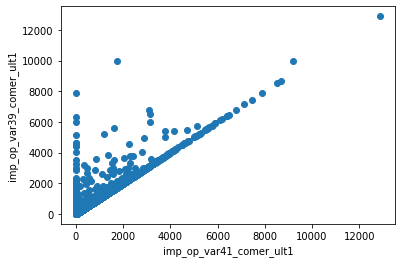

In [368]:
#Plotting one of the highly correlated pair of variables
plt.scatter(trainData["imp_op_var41_comer_ult1"],trainData["imp_op_var39_comer_ult1"])
plt.xlabel("imp_op_var41_comer_ult1")
plt.ylabel("imp_op_var39_comer_ult1")
plt.show()

In [369]:
#Remove highly correlated columns except for target column
arr=corr_matrix.values
index_names=corr_matrix.index
col_names=corr_matrix.columns

#Get indices where threshold of 0.98 is crossed; avoid diagonal elements
R,C=np.where(np.triu(arr,1) > 0.98)

#Arrange those in columns and put out as a dataframe
out_arr=np.column_stack((index_names[R],col_names[C],arr[R,C]))
df_out=pd.DataFrame(out_arr,columns=['row_name','col_name','corr_value'])

#Remove columns listed in col_name and keep columns in row_name ( Need to keep only 1 of related columns)
df_out=df_out.sort_values(by = 'corr_value', ascending = False)
df_out=df_out.query('row_name != col_name')
trainData.drop(df_out['col_name'].unique(),axis=1, inplace=True)
testData.drop(df_out['col_name'].unique(),axis=1, inplace=True)

print("trainData shape after removing highly correlated columns: ",trainData.shape)
print("testData shape after removing highly correlated columns: ",testData.shape)

trainData shape after removing highly correlated columns:  (76020, 231)
testData shape after removing highly correlated columns:  (75818, 231)


In [370]:
#Remove duplicate data
trainData=trainData.drop_duplicates()
testData=testData.drop_duplicates()

print("trainData shape after removing duplicate rows: ",trainData.shape)
print("testData shape after removing duplicate rows: ",testData.shape)

trainData shape after removing duplicate rows:  (71179, 231)
testData shape after removing duplicate rows:  (75818, 231)


# Dividing training data

In [371]:
df = pd.DataFrame(trainData.TARGET.value_counts())
df.head()

,TARGET
0,68364
1,2815


In [372]:
X = trainData.iloc[:, :-1]
X.head()

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_largo_0,ind_var13_medio_0,ind_var14_0,ind_var14,ind_var17_0,ind_var17,ind_var18_0,ind_var19,ind_var20_0,ind_var20,ind_var24_0,ind_var24,...,num_op_var41_efect_ult1,num_op_var41_efect_ult3,num_reemb_var17_ult1,num_sal_var16_ult1,num_var43_emit_ult1,num_var43_recib_ult1,num_trasp_var11_ult1,num_trasp_var33_in_hace3,num_trasp_var33_in_ult1,num_venta_var44_hace3,num_venta_var44_ult1,num_var45_hace2,num_var45_hace3,num_var45_ult1,saldo_medio_var5_hace2,saldo_medio_var5_hace3,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
0,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170
1,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,88.89,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,300.0,122.22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030
2,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.00,0.18,3.00,2.07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770
3,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,0.0,195.0,195.0,0.0,0.0,195.0,0.0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,27,3,18,186.09,0.00,91.56,138.84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970
4,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,3,6,3,0,0,0,0,0,0,0,3.00,0.30,40501.08,13501.47,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979


In [373]:
#Select Y Target Column from the Train file
Y = trainData.iloc[:, -1]
Y.head()

0    0
1    0
2    0
3    0
4    0
Name: TARGET, dtype: int64

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 0)

# Basic Decision Tree Classifier model

In [375]:
#Basic model
clf=DecisionTreeClassifier()
clf.fit(x_train,y_train)
pred=pd.DataFrame(clf.predict(x_test),columns=["Target"])
pred.head()

,Target
0,0
1,0
2,0
3,0
4,0


In [376]:
print("Accuracy score for base model is", clf.score(x_test,y_test))
print("Confusion matrix for base model: \n", confusion_matrix(y_test, pred))
print(classification_report(y_test,pred))

Accuracy score for base model is 0.9234616465299241
Confusion matrix for base model: 
 [[16352   724]
 [  638    81]]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     17076
           1       0.10      0.11      0.11       719

    accuracy                           0.92     17795
   macro avg       0.53      0.54      0.53     17795
weighted avg       0.93      0.92      0.93     17795



# Fine Tuning the model

##Model 1

In [0]:
#Create Decision Tree Classifier Model 1 - Maximum depth
clf=DecisionTreeClassifier(min_samples_split=10)
clf.fit(x_train,y_train)
#Making prediction with Model 1
pred=pd.DataFrame(clf.predict(x_test),columns=["Target"])
pred.head()

In [377]:
print("Accuracy score for model 1 is", clf.score(x_test,y_test))
print("Confusion matrix for model 1: \n", confusion_matrix(y_test, pred))
print(classification_report(y_test,pred))

Accuracy score for model 1 is 0.9234616465299241
Confusion matrix for model 1: 
 [[16352   724]
 [  638    81]]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     17076
           1       0.10      0.11      0.11       719

    accuracy                           0.92     17795
   macro avg       0.53      0.54      0.53     17795
weighted avg       0.93      0.92      0.93     17795



##Model 2

In [378]:
#Model 2
clf=DecisionTreeClassifier(criterion = "entropy", splitter = "random", max_leaf_nodes = 50)
clf.fit(x_train,y_train)
#Make prediction with Model 2
pred=pd.DataFrame(clf.predict(x_test),columns=["Target"])
pred.head()

,Target
0,0
1,0
2,0
3,0
4,0


In [379]:
print("Accuracy score for model 2 is", clf.score(x_test,y_test))
print("Confusion matrix for model 2: \n", confusion_matrix(y_test, pred))
print(classification_report(y_test,pred))

Accuracy score for model 2 is 0.9594830008429334
Confusion matrix for model 2: 
 [[17072     4]
 [  717     2]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     17076
           1       0.33      0.00      0.01       719

    accuracy                           0.96     17795
   macro avg       0.65      0.50      0.49     17795
weighted avg       0.93      0.96      0.94     17795



##Model 3

In [380]:
clf=DecisionTreeClassifier(min_samples_leaf=10)
clf.fit(x_train,y_train)
#Make prediction with Model 3
pred=pd.DataFrame(clf.predict(x_test),columns=["Target"])
pred.head()

,Target
0,0
1,0
2,0
3,0
4,0


In [381]:
print("Accuracy score for model 3 is", clf.score(x_test,y_test))
print("Confusion matrix for model 3: \n", confusion_matrix(y_test, pred))
print(classification_report(y_test,pred))

Accuracy score for model 3 is 0.9565046361337455
Confusion matrix for model 3: 
 [[16988    88]
 [  686    33]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     17076
           1       0.27      0.05      0.08       719

    accuracy                           0.96     17795
   macro avg       0.62      0.52      0.53     17795
weighted avg       0.93      0.96      0.94     17795



#Fitting test data into model

In [382]:
#Test data prediction
clf=DecisionTreeClassifier(min_samples_leaf=10)
clf.fit(X,Y)
pred_t=pd.DataFrame(clf.predict(testData),columns=["Target"])

ValueError: ignored

In [0]:
pred_test=pd.DataFrame(clf.predict(x_test),columns=["Prediction"])
pred_test.head()

In [346]:
pred_Probability =pd.DataFrame(clf.predict_proba(x_test))
pred_Probability.head()

,0,1
0,1.000000,0.000000
1,0.900000,0.100000
2,1.000000,0.000000
3,1.000000,0.000000
4,0.833333,0.166667


In [384]:
ID=testData.iloc[:,0]
pd.concat([ID, pred_t],axis=1).to_csv("/gdrive/My Drive/Results/SantandarFinalResult.csv", index = None)
res=pd.read_csv('/gdrive/My Drive/Results/SantandarFinalResult.csv')
res.head()

,ID,Target
0,2,0.0
1,5,0.0
2,6,0.0
3,7,0.0
4,9,0.0
